In [ ]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'main__fastscnn_hyperparameters_tuning'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [1]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.local.LEDNet.models import lednet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
from models import config
from slurm_scripts import slurm_config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [2]:
# defining transforms
test_image_transform = T.Compose([T.Resize(slurm_config.GLOBAL_INPUT_SIZE_TRAINING_DEMO), T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])
test_target_transform = T.Compose([T.Resize(slurm_config.GLOBAL_INPUT_SIZE_TRAINING_DEMO)])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
_, X_test, _, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
test_dataset = dataset.CcncsaDataset(X_test, Y_test, test_image_transform, test_target_transform)

# loading best model
model_name = 'lednet_ccncsa_demo'
model = lednet.LEDNet(num_classes=n_classes, output_size=slurm_config.GLOBAL_INPUT_SIZE_TRAINING_DEMO)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_score_fn = metrics.batch_IoU
class_weights = torch.tensor(config.CLASS_WEIGHTS, device=device)
batch_IoU = training_and_testing.test_model(device, model, test_dataset, batch_size, test_score_fn)

# printing test report
training_and_testing.print_IoU_report(batch_IoU, class_weights)

Device: cuda.

Inference completed in around 262 seconds.
batch_IoU_background: 0.9549016356468201
batch_IoU_lips: 0.5214775204658508
batch_IoU_eyes: 0.36390525102615356
batch_IoU_nose: 0.7028884887695312
batch_IoU_skin: 0.8496889472007751
batch_IoU_hair: 0.7904947400093079
batch_IoU_eyebrows: 0.36546361446380615
batch_IoU_ears: 0.6305446028709412
batch_IoU_teeth: 0.675483226776123
batch_IoU_beard: 0.8670912384986877
batch_IoU_sunglasses: 0.9053428769111633
batch_mIoU=0.6933892965316772
batch_weighted_mIoU=0.6724995374679565


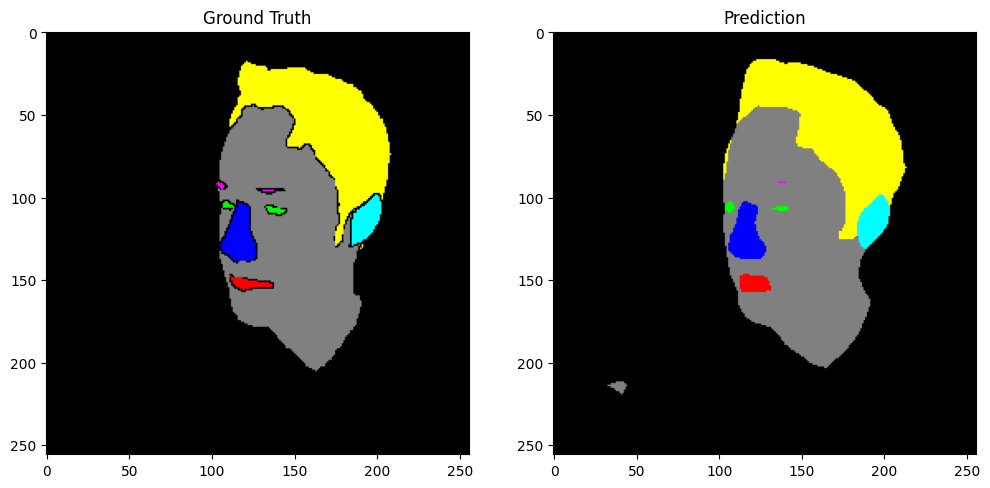

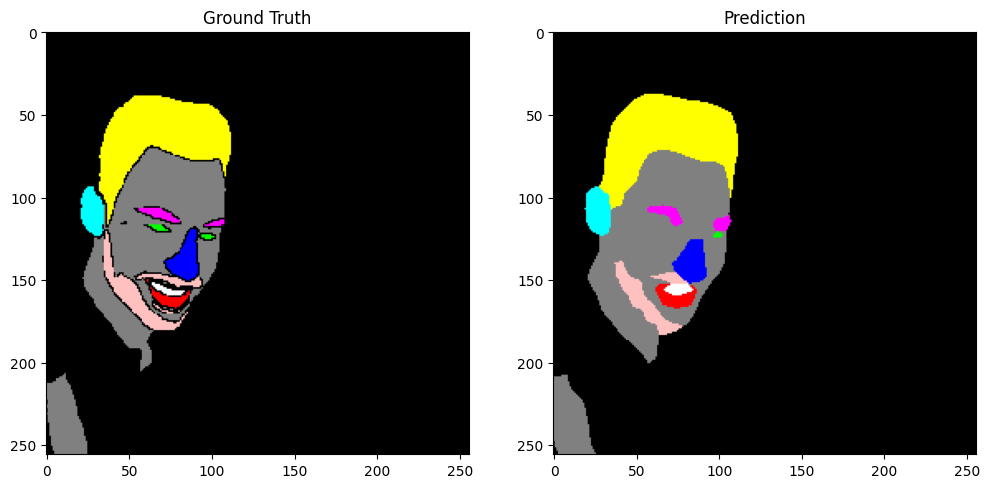

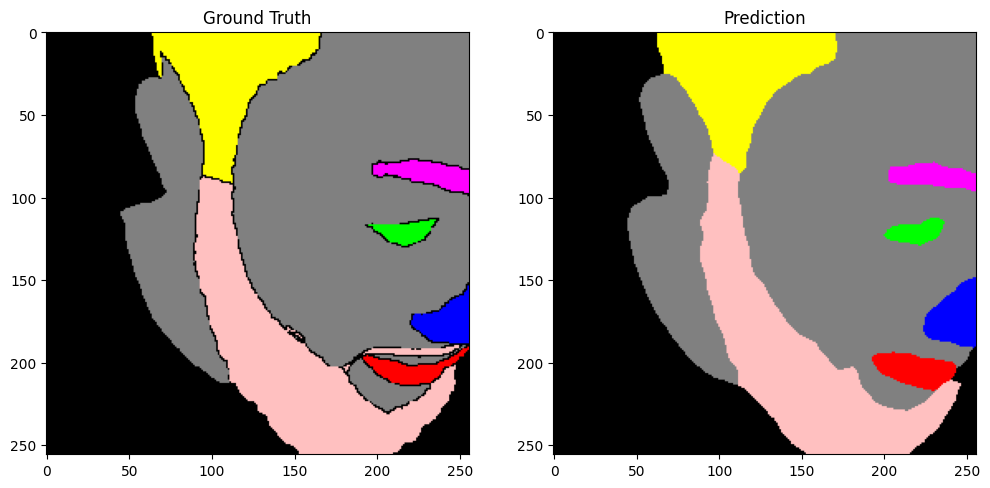

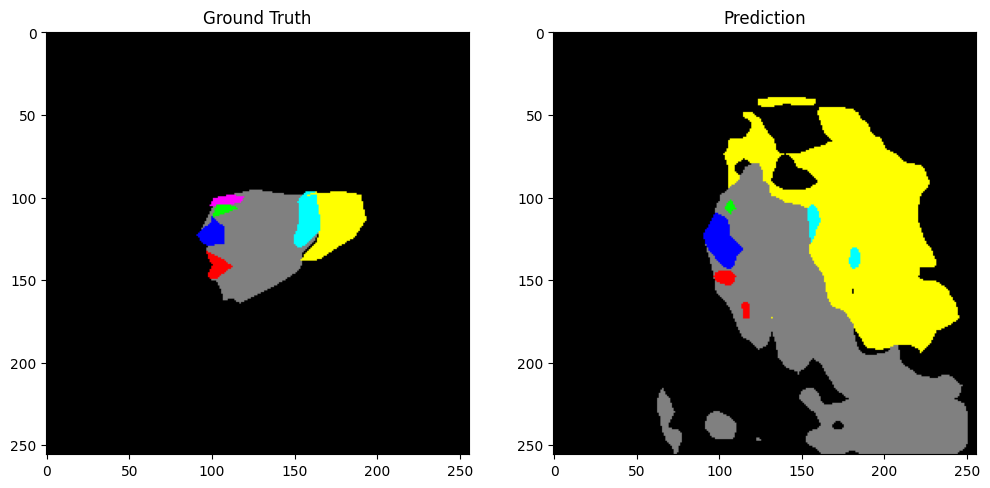

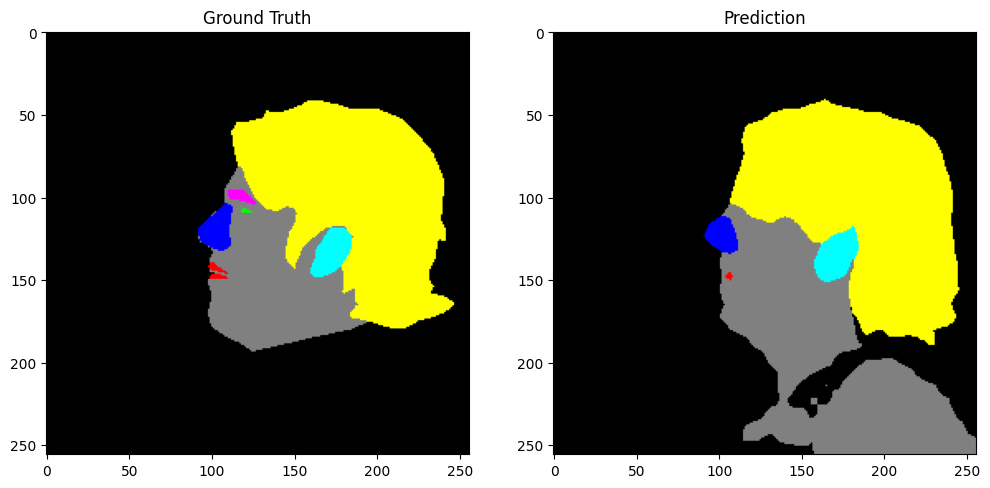

In [3]:
# plotting some examples from test dataset
utils.plot_random_examples(device, model, test_dataset, n_examples=5)